In [1]:
#Importing packages
from selenium import webdriver
import pandas as pd
import numpy as np

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from itertools import chain
nltk.download('punkt')
nltk.download('wordnet')

import matplotlib.pyplot as plt
%matplotlib inline  

pd.set_option('display.max_rows', 500)

## Scraper
First of all, don't run it!, it took me hours to scrape all the data (It should not have taken so long but I don't know why).

Secondly, I scraped around 7500 most recent pieces of comment instead of 5000 because the most recent 5000 comments are contributed by 68 users. With 7500 comments, we can get opioins from 130 users, which diversifys our data.

In [16]:
# %%time

# #change directory where you put your chrome driver
# options = webdriver.ChromeOptions()
# options.add_argument('headless')
# driver = webdriver.Chrome("chromedriver", options=options)

# all_comments = pd.DataFrame(columns = ['Date','user_id', 'comments']) 

# x = 284
# pages_scraped = 434
# driver.get('https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p{}'.format(x))

# while x <= pages_scraped:
#     print("page",x)
    
#     if x > 1:
#         driver.find_element_by_link_text("{}".format(x)).click()
#         driver.implicitly_wait(3)
    
#     ids = driver.find_elements_by_xpath("//*[contains(@id,'Comment_')]")
#     comment_ids = []
#     for i in ids:
#         comment_ids.append(i.get_attribute('id'))

#     for d in comment_ids:

#         #Extract dates from for each user on a page
#         user_date = driver.find_elements_by_xpath('//*[@id="' + d +'"]/div/div[2]/div[2]/span[1]/a/time')[0]
#         date = user_date.get_attribute('title')

#         #Extract user ids from each user on a page
#         userid_element = driver.find_elements_by_xpath('//*[@id="' + d +'"]/div/div[2]/div[1]/span[1]/a[2]')[0]
#         userid = userid_element.text

#         #Extract Message for each user on a page
#         if driver.find_elements_by_xpath('//*[@id="' + d +'"]/div/div[3]/div/div[1]/p'):
#             user_message = driver.find_elements_by_xpath('//*[@id="' + d +'"]/div/div[3]/div/div[1]/p')[0]
#             comment = user_message.text
#         elif driver.find_elements_by_xpath('//*[@id="' + d +'"]/div/div[3]/div/div[1]/ul/li'):
#             user_message = driver.find_elements_by_xpath('//*[@id="' + d +'"]/div/div[3]/div/div[1]/ul/li')[0]
#             comment = user_message.text
#         elif driver.find_elements_by_xpath('//*[@id="' + d +'"]/div/div[3]/div/div[1]'):
#             user_message = driver.find_elements_by_xpath('//*[@id="' + d +'"]/div/div[3]/div/div[1]')[0]
#             comment = user_message.text
#         else: 
#             comment = None
        
#         #Adding date, userid and comment for each user in a dataframe    
#         all_comments.loc[len(all_comments)] = [date,userid,comment]
        
#     x += 1

In [69]:
# all_comments.to_csv("7500_comments_edmunds.csv", sep="\t")

## Check the data
We have 7506 rows of comments from 2012-8-10 to 2019-8-21, comtibuted by 130 users.

In [2]:
df = pd.read_csv("7500_comments_edmunds.csv", sep="\t", parse_dates=['Date'])
df = df[['Date', 'user_id', 'comments']]
df = df.dropna()

In [57]:
df.shape

(7506, 3)

In [58]:
df['Date'].max()

Timestamp('2019-08-21 02:25:00')

In [59]:
df['Date'].min()

Timestamp('2012-08-10 01:45:00')

In [60]:
len(df['user_id'].value_counts())

130

### Preprocess comments

In [5]:
%%time
# tokenization
df['tokens'] = df['comments'].map(nltk.word_tokenize)
df['tokens'] = df['tokens'].map(lambda x: set(x))

# lemmatization
lemmatizer = WordNetLemmatizer()
df['lemmatized'] = df ['tokens'].map(lambda x: [lemmatizer.lemmatize(word) for word in x])
df['lemmatized'] = df['lemmatized'].map(lambda x: set(x))

# remove stop words
stop_words = set(stopwords.words('english'))
df['processed'] = df['lemmatized'].map(lambda x: [word for word in x if word.lower() not in stop_words])

# remove punctuations
punc = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~..."
df['processed'] = df['processed'].map(lambda x: [word for word in x if word.lower() not in punc])

# remove some other stuff and return lower case
others = ["''", "``", "n't", "l", "oh", "lol", "'m", "'s"]
df['processed'] = df['processed'].map(lambda x: [word.lower() for word in x if word.lower() not in others])

Wall time: 8.53 s


## Replace model to brand

In [6]:
models = pd.read_csv("models (5).csv", header = None)
models.columns = ['brand', 'model']

In [7]:
## clean brand list
models.loc[(models['brand'] == 'mercedes'),'brand'] = 'mercedes-benz'
models.loc[(models['brand'] == 'kia.'),'brand'] = 'kia'

In [8]:
def model_to_brand(word):
    if word.lower() in models['model'].values:
        brand = models[models['model'] == word].iloc[-1,0]
        print('replace ' + word + ' to ' + brand)
        return(brand)
    else:
        return(word)

In [9]:
df['processed'] = df['processed'].map(lambda x: [model_to_brand(word) for word in x])

replace 4-series to bmw
replace 6-series to bmw
replace accent to hyundai
replace 3-series to bmw
replace legacy to subaru
replace focus to ford
replace mercedes to mercedes-benz
replace focus to ford
replace camry to toyota
replace cx-7 to mazda
replace colorado to chevrolet
replace quattro to audi
replace cavalier to chevrolet
replace comfort to toyota
replace cruiser to chrysler
replace a4 to audi
replace lacrosse to buick
replace passat to volkwagen
replace ilx to acura
replace a4 to audi
replace quattro to audi
replace a3 to audi
replace a4 to audi
replace quattro to audi
replace a3 to audi
replace passat to volkwagen
replace jetta to volkswagen
replace quattro to audi
replace tsx to acura
replace a3 to audi
replace tsx to acura
replace quattro to audi
replace a3 to audi
replace a4 to audi
replace ilx to acura
replace ilx to acura
replace rlx to acura
replace tsx to acura
replace 328i to bmw
replace tsx to acura
replace tsx to acura
replace tsx to acura
replace legend to honda
rep

replace comfort to toyota
replace mercedes to mercedes-benz
replace accord to honda
replace q50 to infiniti
replace accord to honda
replace camry to toyota
replace a4 to audi
replace m3 to bmw
replace 328i to bmw
replace leaf to nissan
replace mercedes to mercedes-benz
replace 335i to bmw
replace 328i to bmw
replace a4 to audi
replace m3 to bmw
replace a3 to audi
replace quattro to audi
replace seats to seat
replace q50 to infiniti
replace a3 to audi
replace legacy to subaru
replace quattro to audi
replace seats to seat
replace q50 to infiniti
replace a3 to audi
replace legacy to subaru
replace legacy to subaru
replace outback to subaru
replace legacy to subaru
replace legacy to subaru
replace q5 to audi
replace a4 to audi
replace m3 to bmw
replace a4 to audi
replace 335i to bmw
replace s60 to volvo
replace g37 to infiniti
replace g37 to infiniti
replace q50 to infiniti
replace q5 to audi
replace xc60 to volvo
replace s60 to volvo
replace mdx to acura
replace focus to ford
replace merc

replace ilx to acura
replace rlx to acura
replace mercedes to mercedes-benz
replace city to honda
replace a3 to audi
replace hondas to honda
replace nsx to honda
replace mercedes to mercedes-benz
replace bmws to bmw
replace bmws to bmw
replace cars to car
replace mercedes to mercedes-benz
replace a6 to audi
replace bmws to bmw
replace escalade to cadillac
replace impala to chevrolet
replace equus to hyundai
replace rlx to acura
replace q7 to audi
replace city to honda
replace a8 to audi
replace bmws to bmw
replace bmws to bmw
replace a4 to audi
replace bmws to bmw
replace bmws to bmw
replace nsx to honda
replace mercedes to mercedes-benz
replace toyotas to toyota
replace s60 to volvo
replace e-class to mercedes-benz
replace genesis to hyundai
replace nsx to honda
replace equus to hyundai
replace rlx to acura
replace rsx to acura
replace optima to kia
replace 528i to bmw
replace genesis to hyundai
replace mercedes to mercedes-benz
replace mustang to ford
replace challenger to dodge
repl

replace vw to volkswagen
replace regal to buick
replace q50 to infiniti
replace s60 to volvo
replace benz to mercedes-benz
replace a3 to audi
replace 3-series to bmw
replace a3 to audi
replace a4 to audi
replace c-class to mercedes-benz
replace m3 to bmw
replace g37 to infiniti
replace 3-series to bmw
replace 335i to bmw
replace a3 to audi
replace a4 to audi
replace c-class to mercedes-benz
replace pilot to honda
replace bmws to bmw
replace m3 to bmw
replace mercedes to mercedes-benz
replace a6 to audi
replace benz to mercedes-benz
replace 328i to bmw
replace sedans to sedan
replace 328i to bmw
replace impala to chevrolet
replace malibu to chevrolet
replace regal to buick
replace m3 to bmw
replace m3 to bmw
replace tsx to acura
replace a4 to audi
replace ilx to acura
replace a3 to audi
replace 5-series to bmw
replace 3-series to bmw
replace accord to honda
replace civic to honda
replace q5 to audi
replace q3 to audi
replace q7 to audi
replace a4 to audi
replace a5 to audi
replace a6 to

replace vw to volkswagen
replace mercedes to mercedes-benz
replace toyotas to toyota
replace nissans to nissan
replace hondas to honda
replace vw to volkswagen
replace jetta to volkswagen
replace bmws to bmw
replace a6 to audi
replace quattro to audi
replace tahoe to chevrolet
replace mercedes to mercedes-benz
replace chevy to chevrolet
replace seats to seat
replace 335i to bmw
replace a6 to audi
replace benz to mercedes-benz
replace vw to volkswagen
replace golf to volkswagen
replace a6 to audi
replace 335i to bmw
replace 335i to bmw
replace m3 to bmw
replace comfort to toyota
replace comfort to toyota
replace charger to dodge
replace charger to dodge
replace comfort to toyota
replace charger to dodge
replace charger to dodge
replace m5 to bmw
replace charger to dodge
replace m5 to bmw
replace m3 to bmw
replace vw to volkswagen
replace golf to volkswagen
replace g8 to pontiac
replace gxp to pontiac
replace challenger to dodge
replace m6 to bmw
replace cruiser to chrysler
replace m6 to

replace xc90 to volvo
replace xc90 to volvo
replace s60 to volvo
replace optima to kia
replace a3 to audi
replace jetta to volkswagen
replace gti to volkswagen
replace a3 to audi
replace mercedes to mercedes-benz
replace gti to volkswagen
replace vw to volkswagen
replace jetta to volkswagen
replace optima to kia
replace mercedes to mercedes-benz
replace golf to volkswagen
replace gti to volkswagen
replace bmws to bmw
replace civic to honda
replace cars to car
replace accord to honda
replace wrx to subaru
replace crv to honda
replace civic to honda
replace pony to hyundai
replace optima to kia
replace m3 to bmw
replace dart to dodge
replace civic to honda
replace wrx to subaru
replace golf to volkswagen
replace civic to honda
replace forester to subaru
replace civic to honda
replace civic to honda
replace civic to honda
replace vw to volkswagen
replace jetta to volkswagen
replace a4 to audi
replace c-class to mercedes-benz
replace gti to volkswagen
replace comfort to toyota
replace m5 t

replace buicks to buick
replace leaf to nissan
replace focus to ford
replace mercedes to mercedes-benz
replace a6 to audi
replace mercedes to mercedes-benz
replace xts to cadillac
replace q5 to audi
replace buicks to buick
replace leaf to nissan
replace focus to ford
replace mercedes to mercedes-benz
replace a6 to audi
replace mercedes to mercedes-benz
replace mx-5 to mazda
replace quattro to audi
replace corvette to chevrolet
replace a6 to audi
replace a6 to audi
replace quattro to audi
replace corvette to chevrolet
replace chevy to chevrolet
replace encore to buick
replace equinox to chevrolet
replace chevy to chevrolet
replace express to chevrolet
replace vw to volkswagen
replace shuttle to honda
replace encore to buick
replace a4 to audi
replace vw to volkswagen
replace equinox to chevrolet
replace chevy to chevrolet
replace a4 to audi
replace vw to volkswagen
replace vw to volkswagen
replace buicks to buick
replace escalade to cadillac
replace mercedes to mercedes-benz
replace a6 

replace click to hyundai
replace charger to dodge
replace charger to dodge
replace gti to volkswagen
replace focus to ford
replace golf to volkswagen
replace focus to ford
replace focus to ford
replace e-class to mercedes-benz
replace 328i to bmw
replace click to hyundai
replace golf to volkswagen
replace focus to ford
replace city to honda
replace escalade to cadillac
replace genesis to hyundai
replace genesis to hyundai
replace escalade to cadillac
replace benz to mercedes-benz
replace q50 to infiniti
replace q50 to infiniti
replace golf to volkswagen
replace focus to ford
replace golf to volkswagen
replace a3 to audi
replace gti to volkswagen
replace golf to volkswagen
replace focus to ford
replace gti to volkswagen
replace impreza to subaru
replace comfort to toyota
replace vw to volkswagen
replace golf to volkswagen
replace focus to ford
replace golf to volkswagen
replace golf to volkswagen
replace sportwagen to volkswagen
replace gti to volkswagen
replace impreza to subaru
replac

replace genesis to hyundai
replace genesis to hyundai
replace m3 to bmw
replace m3 to bmw
replace g37 to infiniti
replace mercedes to mercedes-benz
replace focus to ford
replace 5-series to bmw
replace mercedes to mercedes-benz
replace mercedes-benz to mercedes-benz
replace e-class to mercedes-benz
replace genesis to hyundai
replace sonata to hyundai
replace genesis to hyundai
replace optima to kia
replace sonata to hyundai
replace genesis to hyundai
replace genesis to hyundai
replace genesis to hyundai
replace genesis to hyundai
replace 528i to bmw
replace camry to toyota
replace genesis to hyundai
replace accord to honda
replace genesis to hyundai
replace equus to hyundai
replace camry to toyota
replace xdrive to bmw
replace xdrive to bmw
replace 5er to bmw
replace genesis to hyundai
replace golf to volkswagen
replace golf to volkswagen
replace benz to mercedes-benz
replace benz to mercedes-benz
replace a8 to audi
replace q7 to audi
replace comfort to toyota
replace comfort to toyota

replace cr-v to honda
replace a4 to audi
replace cr-v to honda
replace a4 to audi
replace pilot to honda
replace accord to honda
replace accord to honda
replace genesis to hyundai
replace m5 to bmw
replace f150 to ford
replace genesis to hyundai
replace cars to car
replace accord to honda
replace cars to car
replace accord to honda
replace cars to car
replace accord to honda
replace accord to honda
replace optima to kia
replace optima to kia
replace comfort to toyota
replace suburban to chevrolet
replace optima to kia
replace vw to volkswagen
replace passat to volkwagen
replace vw to volkswagen
replace passat to volkwagen
replace vw to volkswagen
replace passat to volkwagen
replace passat to volkwagen
replace vw to volkswagen
replace passat to volkwagen
replace passat to volkwagen
replace a4 to audi
replace a4 to audi
replace escalade to cadillac
replace a4 to audi
replace benz to mercedes-benz
replace city to honda
replace city to honda
replace city to honda
replace colorado to chevro

replace ilx to acura
replace corolla to toyota
replace camry to toyota
replace civic to honda
replace a3 to audi
replace hondas to honda
replace accord to honda
replace vw to volkswagen
replace chevy to chevrolet
replace camry to toyota
replace comfort to toyota
replace rdx to acura
replace ilx to acura
replace a3 to audi
replace a4 to audi
replace ilx to acura
replace a3 to audi
replace quattro to audi
replace a4 to audi
replace a4 to audi
replace rlx to acura
replace rlx to acura
replace cr-v to honda
replace vw to volkswagen
replace vw to volkswagen
replace chevy to chevrolet
replace fords to ford
replace 3er to bmw
replace mercedes to mercedes-benz
replace benz to mercedes-benz
replace q50 to infiniti
replace q50 to infiniti
replace vw to volkswagen
replace passat to volkwagen
replace chevy to chevrolet
replace camry to toyota
replace charger to dodge
replace m5 to bmw
replace charger to dodge
replace m5 to bmw
replace rdx to acura
replace ex-l to honda
replace cr-v to honda
replac

replace crv to honda
replace 328i to bmw
replace rogue to nissan
replace comfort to toyota
replace 335i to bmw
replace 335i to bmw
replace 535i to bmw
replace vw to volkswagen
replace golf to volkswagen
replace m3 to bmw
replace altima to nissan
replace genesis to hyundai
replace genesis to hyundai
replace equus to hyundai
replace elantra to hyundai
replace mercedes to mercedes-benz
replace legacy to subaru
replace mercedes to mercedes-benz
replace legend to honda
replace a6 to audi
replace g37 to infiniti
replace altima to nissan
replace g37 to infiniti
replace 335i to bmw
replace m3 to bmw
replace 335i to bmw
replace mercedes to mercedes-benz
replace 335i to bmw
replace mercedes to mercedes-benz
replace 335i to bmw
replace 335i to bmw
replace 328i to bmw
replace m3 to bmw
replace tsx to acura
replace mercedes-benz to mercedes-benz
replace a6 to audi
replace genesis to hyundai
replace 328i to bmw
replace genesis to hyundai
replace genesis to hyundai
replace leaf to nissan
replace merc

replace rogue to nissan
replace express to chevrolet
replace g37 to infiniti
replace g37 to infiniti
replace 328i to bmw
replace q5 to audi
replace q3 to audi
replace q7 to audi
replace bmws to bmw
replace malibu to chevrolet
replace bmws to bmw
replace q5 to audi
replace q3 to audi
replace q7 to audi
replace tsx to acura
replace accord to honda
replace accord to honda
replace tsx to acura
replace accord to honda
replace accord to honda
replace civic to honda
replace quattro to audi
replace 335i to bmw
replace 328i to bmw
replace 328i to bmw
replace pilot to honda
replace 3er to bmw
replace bmws to bmw
replace odyssey to honda
replace rdx to acura
replace rdx to acura
replace cx-5 to mazda
replace mazda6 to mazda
replace prius to toyota
replace city to honda
replace 328i to bmw
replace a4 to audi
replace camry to toyota
replace century to toyota
replace prius to toyota
replace vw to volkswagen
replace jetta to volkswagen
replace golf to volkswagen
replace 335d to bmw
replace city to ho

replace golf to volkswagen
replace a4 to audi
replace bmws to bmw
replace tsx to acura
replace bmws to bmw
replace g37 to infiniti
replace avalon to toyota
replace genesis to hyundai
replace avalon to toyota
replace bmws to bmw
replace 535i to bmw
replace camry to toyota
replace prelude to honda
replace pilot to honda
replace accord to honda
replace 328i to bmw
replace a4 to audi
replace wrx to subaru
replace accord to honda
replace genesis to hyundai
replace genesis to hyundai
replace comfort to toyota
replace camry to toyota
replace wrx to subaru
replace expedition to ford
replace bmws to bmw
replace impala to chevrolet
replace avalon to toyota
replace xdrive to bmw
replace m5 to bmw
replace 5-series to bmw
replace vw to volkswagen
replace cruze to chevrolet
replace ram to dodge
replace suburban to chevrolet
replace spark to chevrolet
replace camry to toyota
replace sedans to sedan
replace s60 to volvo
replace a4 to audi
replace a6 to audi
replace s60 to volvo
replace a4 to audi
repl

replace tsx to acura
replace chevy to chevrolet
replace g37 to infiniti
replace q50 to infiniti
replace 335i to bmw
replace buicks to buick
replace fusion to ford
replace g37 to infiniti
replace azera to hyundai
replace q50 to infiniti
replace sonata to hyundai
replace sonatas to hyundai
replace q50 to infiniti
replace a6 to audi
replace quattro to audi
replace rdx to acura
replace mazda6 to mazda
replace accord to honda
replace leaf to nissan
replace a3 to audi
replace accord to honda
replace a4 to audi
replace accord to honda
replace a4 to audi
replace altima to nissan
replace accord to honda
replace vw to volkswagen
replace g37 to infiniti
replace avalon to toyota
replace camry to toyota
replace maxima to nissan
replace a4 to audi
replace tsx to acura
replace accord to honda
replace ex-l to honda
replace a3 to audi
replace gti to volkswagen
replace accord to honda
replace mercedes to mercedes-benz
replace xdrive to bmw
replace 335i to bmw
replace 328i to bmw
replace xdrive to bmw
re

replace a4 to audi
replace comfort to toyota
replace 335d to bmw
replace 3-series to bmw
replace 328i to bmw
replace 3-series to bmw
replace vw to volkswagen
replace s60 to volvo
replace stream to honda
replace chevy to chevrolet
replace toyotas to toyota
replace fords to ford
replace express to chevrolet
replace chevy to chevrolet
replace s60 to volvo
replace s60 to volvo
replace explorer to ford
replace s60 to volvo
replace mercedes to mercedes-benz
replace charger to dodge
replace s60 to volvo
replace vw to volkswagen
replace s60 to volvo
replace gti to volkswagen
replace bmws to bmw
replace comfort to toyota
replace 328i to bmw
replace a4 to audi
replace a3 to audi
replace g37 to infiniti
replace q50 to infiniti
replace a6 to audi
replace mercedes to mercedes-benz
replace 335i to bmw
replace a4 to audi
replace vw to volkswagen
replace bmws to bmw
replace charger to dodge
replace mercedes to mercedes-benz
replace benz to mercedes-benz
replace xts to cadillac
replace xts to cadillac


## Check frequency

In [10]:
all_words = pd.Series(chain(*list(df['processed'])))
word_frequency = all_words.value_counts()
word_frequency

car                                                                                                    3430
bmw                                                                                                    2551
wa                                                                                                     2300
like                                                                                                   2075
said                                                                                                   2054
one                                                                                                    2040
would                                                                                                  1965
audi                                                                                                   1911
ha                                                                                                     1733
get                         

## Task A: get top 10 list
Filter brands from word_frequency

In [11]:
brand_list = models['brand'].drop_duplicates().values
no_use = ['car', 'sedan', 'seat', 'problem']
brand_list = [ x for x in brand_list if x not in no_use]

In [14]:
tmp = pd.DataFrame(word_frequency)
tmp['word'] = word_frequency.index
mask = tmp['word'].isin(brand_list)
brand_frequency = word_frequency[mask]
top10_brands = brand_frequency.head(10)
top10_brands

bmw              2551
audi             1911
acura            1134
honda            1000
infiniti          662
toyota            488
volkswagen        483
mercedes-benz     411
hyundai           396
ford              376
dtype: int64

## Task A: calculate lift ratios for associations between the brands

#### Test case

In [26]:
# lift(bmw, audi)
a = 'bmw'
b = 'audi'
N = df['processed'].shape[0]
N_ab = sum(df['processed'].map(lambda x: a in x and b in x))
N_a = sum(df['processed'].map(lambda x: a in x))
N_b = sum(df['processed'].map(lambda x: b in x))
print(N, N_ab, N_a, N_b, N*N_ab/(N_a*N_b))

def lift(a, b):
    N = df['processed'].shape[0]
    N_ab = sum(df['processed'].map(lambda x: a in x and b in x))
    N_a = sum(df['processed'].map(lambda x: a in x))
    N_b = sum(df['processed'].map(lambda x: b in x))
    return(N*N_ab/(N_a*N_b))

7506 567 1930 1234 1.7869777714328903


In [31]:
lift_brands = pd.DataFrame(top10_brands.index.values, columns=['brand'])
for make in top10_brands.index.values:
    lift_brands[make] = lift_brands['brand'].map(lambda x: lift(x, make))
lift_brands = lift_brands.set_index('brand')
lift_brands

,bmw,audi,acura,honda,infiniti,toyota,volkswagen,mercedes-benz,hyundai,ford
brand,,,,,,,,,,
bmw,3.889119,1.786978,1.325522,1.098865,1.894895,1.380993,1.200739,2.622126,1.247200,1.406985
audi,1.786978,6.082658,2.173920,1.583850,2.593196,1.508753,2.675705,3.480728,1.803823,1.224836
acura,1.325522,2.173920,8.882840,3.260322,3.298343,1.553917,1.359123,2.617041,1.531524,1.121724
honda,1.098865,1.583850,3.260322,10.396122,1.409297,3.202983,2.073543,1.737595,1.828284,2.022454
infiniti,1.894895,2.593196,3.298343,1.409297,14.746562,1.617116,1.329608,3.467322,2.034009,1.258239
toyota,1.380993,1.508753,1.553917,3.202983,1.617116,19.597911,2.302487,1.998654,3.041055,2.742370
volkswagen,1.200739,2.675705,1.359123,2.073543,1.329608,2.302487,20.508197,1.742906,2.192256,2.799754
mercedes-benz,2.622126,3.480728,2.617041,1.737595,3.467322,1.998654,1.742906,21.263456,2.126346,2.177146
hyundai,1.247200,1.803823,1.531524,1.828284,2.034009,3.041055,2.192256,2.126346,25.882759,2.031752


## MDS plot

In [50]:
from sklearn.manifold import MDS
embedding = MDS(n_components=2)
mds = embedding.fit_transform(lift_brands)
mds = pd.DataFrame(mds, index=lift_brands.index.values, columns=['x', 'y'])
mds

C:\Users\spong\Anaconda3\envs\test\lib\site-packages\sklearn\manifold\mds.py:421: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


,x,y
bmw,-0.462709,-2.402158
audi,2.048323,-3.064739
acura,3.831694,1.251144
honda,-2.907083,2.905226
infiniti,8.702169,-8.336631
toyota,6.896691,14.553180
volkswagen,-3.773015,-17.567089
mercedes-benz,18.886347,-0.475843
hyundai,-11.804703,18.967916
ford,-21.417715,-5.831005


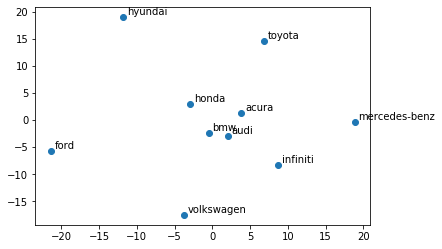

In [57]:
fig, ax = plt.subplots()
ax.scatter(mds['x'], mds['y'])
for brand in lift_brands.index.values:
    ax.text(mds.loc[brand, 'x']+0.5, mds.loc[brand, 'y']+0.5, brand)

##  <font color='red'>Task B: Insights</fonr>
TBD

## Task C
I went over 1500 words, picked and grouped words with intuition. 

Since professor said we don't have to do a sentiment analysis, I group positive and negative words together. For example, I grouped 'small' and 'large' into size attributes. 

Find 5 most frequently mentioned attributes.

In [66]:
word_frequency[:500]

car               3430
bmw               2551
wa                2300
like              2075
said              2054
one               2040
would             1965
audi              1911
ha                1733
get               1655
new               1508
think             1482
year              1348
even              1273
time              1188
good              1185
acura             1134
much              1132
well              1125
know              1070
really            1069
drive             1023
honda             1000
still              983
doe                983
could              978
price              973
make               973
go                 925
also               922
better             915
dealer             897
see                855
thing              847
look               833
want               824
people             816
say                815
way                796
've                777
back               756
3                  741
model              721
going      

In [69]:
attributes = { 
    'performance': ['drive', 'engine', 'sport', 'driving', 'performance', 'power', 'spped', 
                    'fast', 'faster', 'sporty', 'horsepower', 'powerful'],
    
    'fuel_efficiency': ['mile', 'mileage', 'oil', 'diesel', 'mpg', 'gas', 'fuel'],
    
    'look': ['look', 'nice', 'looking', 'design', 'nicer', 'style', 'attractive', 'designed', 'looked'],
    
    'luxury': ['great', 'brand', 'luxury', 'best', 'premium'],
    
    'reliability': ['issue', 'problem', 'recall', 'trouble', 'concerned', 'suspension', 'reliable',
                   'service', 'warranty', 'durability', 'quality'],
    
    'price': ['money', 'msrp', 'price', 'sale', 'offer', 'discount', 'bargain', 'grand', 'expensive',
             'cheap', 'cheaper', 'incentive', 'worth'],
    
    'size': ['big', 'huge', 'large', 'size', 'weight', 'bigger', 'sticker', 'roof',
            'little', 'small', 'light', 'smaller', 'biggest'],

    'interior': ['seat', 'interior', 'leather', 'steering', 'inside', 'radio', 'noise', 'quiet'],

    'experience': ['experience', 'speciall', 'interesting', 'impressive', 'surprised', 'amazing', 
                   'fun', 'happy', 'enthusiast'],
    
    'safety': ['safety', 'life', 'safe']}

In [74]:
def count_attribute(df, attribute_terms):
    return(np.sum(df['processed'].map(lambda x: len([term for term in attribute_terms if term in x])>=1 )))

In [75]:
top_attributes = pd.DataFrame(pd.Series(attributes), columns=['attribute_terms'])
top_attributes['count'] = top_attributes['attribute_terms'].map(lambda x: count_attribute(df, x))

In [80]:
top_attributes.sort_values(by=['count'], ascending=False)

,attribute_terms,count
performance,"[drive, engine, sport, driving, performance, p...",2646
price,"[money, msrp, price, sale, offer, discount, ba...",2259
look,"[look, nice, looking, design, nicer, style, at...",1863
size,"[big, huge, large, size, weight, bigger, stick...",1716
luxury,"[great, brand, luxury, best, premium]",1654
reliability,"[issue, problem, recall, trouble, concerned, s...",1652
fuel_efficiency,"[mile, mileage, oil, diesel, mpg, gas, fuel]",1362
experience,"[experience, speciall, interesting, impressive...",1262
interior,"[seat, interior, leather, steering, inside, ra...",1108
safety,"[safety, life, safe]",281
